# Hourly and 10-min buoy data collocation with Saildrone data for validation

This is the code that collocations the Saildrone and buoy data for validation
First there is some reampling of the Saildrone data to match to averaging done by buoys
Buoy sample 10 min averages with the time at the end of the average


In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import atan2, log, pi, sin, cos
import datetime as dt

Read in Saildrone data and resample to match buoy averaging
- 10 min = time at end of 10 min ave
- hour = last 8 minutes of hour included

In [2]:
def read_saildrone(filename_usv):
    #filename_usv='F:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-EP-sd1002-ALL-1_min-v1.nc'
    ds_usv=xr.open_dataset(filename_usv)
    ds_usv.close()
    ds_usv = ds_usv.sel(trajectory=1002)
    ilen_usv=(len(ds_usv.latitude['obs']))
    ds_usv=ds_usv.rename({'latitude':'lat','longitude':'lon'})
#used to create a whole new dataset to switch obs to time but found swap dim command
    ds_usv=ds_usv.swap_dims({'obs':'time'})
    #WS_height=int(ds_usv.UWND_MEAN.installed_height)
    
    lon = ds_usv.lon
    lat = ds_usv.lat
    del ds_usv['lon']
    del ds_usv['lat']
    ds_usv['lon'] = ('time', lon)
    ds_usv['lat'] = ('time', lat)   
    
    #usv is at 5 m, buoys are at 5m.  leave alone rather than changing to 10m wind
    ds_usv['VWND_MEAN'] = (ds_usv.VWND_MEAN*log(10./1e-4))/log(5.0/1e-4)
    ds_usv['UWND_MEAN'] = (ds_usv.UWND_MEAN*log(10./1e-4))/log(5.0/1e-4)

    #ds_usv['UWND_MEAN'] = (ds_usv.UWND_MEAN*log(10./1e-4))/log(WS_height/1e-4)
    #ds_usv['VWND_MEAN'] = (ds_usv.VWND_MEAN*log(10./1e-4))/log(WS_height/1e-4)
    #ds_usv['UWND_MEAN'] = (ds_usv.UWND_MEAN*log(10./1e-4))/log(WS_height/1e-4)
    #ds_usv['VWND_MEAN'] = (ds_usv.VWND_MEAN*log(10./1e-4))/log(WS_height/1e-4)
    #make 10 min averages with time at end of average like buoy data
    ds_usv_10min = ds_usv.resample(time='10min', skipna=True, closed='right', label='right').mean('time') 

    #this calculates hourly data that only uses the last 8 minutes of each hour for the average
    sub = ds_usv.copy(deep=True)
    pt = pd.to_datetime(sub.time.data)
    pmin=pt.minute
    tem=sub.where(pmin>=52)  #data average should be only use min 52  to :60 
    ds_usv_1hr = tem.resample(time='1h', skipna=True, label='right').mean()
    return ds_usv_10min,ds_usv_1hr
 

Read in buoy data.  There are redundant sensors so you have to check the quality of the values and use the best quality only

In [3]:
def get_buoy_data(ibuoy):
    if ibuoy==0:
        sbuoy_id,sdep=['46011','D5']
    if ibuoy==1:
        sbuoy_id,sdep=['46012','D5']
    if ibuoy==2:
        sbuoy_id,sdep=['46042','D4']
    if ibuoy==3:
        sbuoy_id,sdep=['46086','D5']
    if ibuoy==4:
        sbuoy_id,sdep=['46028','D6']       
    if ibuoy==5:
        sbuoy_id,sdep=['46047','D6']

    fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201804_'+sdep+'_v0010min_xrformat.nc'
    xr_buoy10=xr.open_dataset(fname)
    fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201805_'+sdep+'_v0010min_xrformat.nc'
    tem=xr.open_dataset(fname)
    xr_buoy10 = xr.concat([xr_buoy10, tem],'time')
    fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201806_'+sdep+'_v0010min_xrformat.nc'
    tem=xr.open_dataset(fname)
    xr_buoy10 = xr.concat([xr_buoy10, tem],'time')
    btime10=xr_buoy10.time
    
#read in hourly buoy data   
    fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201804_'+sdep+'_v00hrly_xrformat.nc'
    xr_buoy=xr.open_dataset(fname)
    fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201805_'+sdep+'_v00hrly_xrformat.nc'
    tem=xr.open_dataset(fname)
    xr_buoy = xr.concat([xr_buoy, tem],'time')
    fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201806_'+sdep+'_v00hrly_xrformat.nc'
    tem=xr.open_dataset(fname)
    xr_buoy = xr.concat([xr_buoy, tem],'time')
    time=xr_buoy.time
    
    xr_buoy['air_pres1']=xr_buoy.air_pres1/100.
    xr_buoy['air_pres2']=xr_buoy.air_pres2/100.
    xr_buoy['air_pres_sea_level1']=xr_buoy.air_pres_sea_level1/100.
    xr_buoy['air_pres_sea_level2']=xr_buoy.air_pres_sea_level2/100.
    
    #caluclate the best SST using quality flags then use these to calculate u and v
    xr_buoy['sst_best']=xr_buoy['sst1'].copy(deep=True)
    xr_buoy['sstqc_best']=xr_buoy['sst1qc'].copy(deep=True)
    xr_buoy['sst_best']=xr_buoy.sst2.where((xr_buoy.sst1qc!=0) & (xr_buoy.sst2qc==0),other=xr_buoy.sst_best)
    xr_buoy['sstqc_best']=xr_buoy.sst2qc.where((xr_buoy.sst1qc!=0) & (xr_buoy.sst2qc==0),other=xr_buoy.sstqc_best)

    #caluclate the best AIR using quality flags then use these to calculate u and v
    xr_buoy['air_best']=xr_buoy['air1'].copy(deep=True)
    xr_buoy['airqc_best']=xr_buoy['air1qc'].copy(deep=True)
    xr_buoy['air_best']=xr_buoy.air2.where((xr_buoy.air1qc!=0) & (xr_buoy.air2qc==0),other=xr_buoy.air_best)
    xr_buoy['airqc_best']=xr_buoy.air2qc.where((xr_buoy.air1qc!=0) & (xr_buoy.air2qc==0),other=xr_buoy.airqc_best) 

    #caluclate the best AIR using quality flags then use these to calculate u and v
    xr_buoy['air_pres_best']=xr_buoy['air_pres1'].copy(deep=True)
    xr_buoy['air_presqc_best']=xr_buoy['air_pres1qc'].copy(deep=True)
    xr_buoy['air_pres_best']=xr_buoy.air_pres2.where((xr_buoy.air_pres1qc!=0) & (xr_buoy.air_pres2qc==0),other=xr_buoy.air_pres_best)
    xr_buoy['air_presqc_best']=xr_buoy.air_pres2qc.where((xr_buoy.air_pres1qc!=0) & (xr_buoy.air_pres2qc==0),other=xr_buoy.air_presqc_best) 

    #caluclate the best AIR using quality flags then use these to calculate u and v
    xr_buoy['air_pres_sea_level_best']=xr_buoy['air_pres_sea_level1'].copy(deep=True)
    xr_buoy['air_pres_sea_levelqc_best']=xr_buoy['air_pres_sea_level1qc'].copy(deep=True)
    xr_buoy['air_pres_sea_level_best']=xr_buoy.air_pres_sea_level2.where((xr_buoy.air_pres_sea_level1qc!=0) & (xr_buoy.air_pres_sea_level2qc==0),other=xr_buoy.air_pres_sea_level_best)
    xr_buoy['air_pres_sea_levelqc_best']=xr_buoy.air_pres_sea_level2qc.where((xr_buoy.air_pres_sea_level1qc!=0) & (xr_buoy.air_pres_sea_level2qc==0),other=xr_buoy.air_pres_sea_levelqc_best) 

    #caluclate the best wind speed and dirction using quality flags then use these to calculate u and v
    xr_buoy['wnd_best']=xr_buoy['wnd1'].copy(deep=True)
    xr_buoy['wdir_best']=xr_buoy['wdir1'].copy(deep=True)
    xr_buoy['wdirqc_best']=xr_buoy['wdir1qc'].copy(deep=True)
    xr_buoy['wnd_best']=xr_buoy.wnd2.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir2qc==0),other=xr_buoy.wnd_best)
    xr_buoy['wnd_best']=xr_buoy.wnd3.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir3qc==0),other=xr_buoy.wnd_best)
    xr_buoy['wnd_best']=xr_buoy.wnd4.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir4qc==0),other=xr_buoy.wnd_best)
    xr_buoy['wdir_best']=xr_buoy.wdir2.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir2qc==0),other=xr_buoy.wdir_best)
    xr_buoy['wdir_best']=xr_buoy.wdir3.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir3qc==0),other=xr_buoy.wdir_best)
    xr_buoy['wdir_best']=xr_buoy.wdir4.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir4qc==0),other=xr_buoy.wdir_best)
    xr_buoy['wdirqc_best']=xr_buoy.wdir2qc.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir2qc==0),other=xr_buoy.wdirqc_best)
    xr_buoy['wdirqc_best']=xr_buoy.wdir3qc.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir3qc==0),other=xr_buoy.wdirqc_best)
    xr_buoy['wdirqc_best']=xr_buoy.wdir4qc.where((xr_buoy.wdir1qc!=0) & (xr_buoy.wdir4qc==0),other=xr_buoy.wdirqc_best)
    #now caluclate the wind vectors & adjust from met convention
    xr_buoy['wnd_best']=xr_buoy.wnd_best.where(xr_buoy.wdirqc_best==0)
    #change to 10m wind
    xr_buoy['wnd_best'] = (xr_buoy.wnd_best*log(10./1e-4))/log(5/1e-4)
    xr_buoy['wdir_best']=xr_buoy.wdir_best.where(xr_buoy.wdirqc_best==0)
    xr_buoy['uwnd_best']=-1*xr_buoy.wnd_best*np.sin((xr_buoy.wdir_best)*pi/180.) #met conv is deg clock from true north, wind from
    xr_buoy['vwnd_best']=-1*xr_buoy.wnd_best*np.cos((xr_buoy.wdir_best)*pi/180.)

    #caluclate the best wind speed and dirction using quality flags then use these to calculate u and v
    xr_buoy10['wnd_best']=xr_buoy10['wnd1'].copy(deep=True)
    xr_buoy10['wdir_best']=xr_buoy10['wdir1'].copy(deep=True)
    xr_buoy10['wdirqc_best']=xr_buoy10['wdir1qc'].copy(deep=True)
    xr_buoy10['wnd_best']=xr_buoy10.wnd2.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir2qc==0),other=xr_buoy10.wnd_best)
    xr_buoy10['wnd_best']=xr_buoy10.wnd3.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir3qc==0),other=xr_buoy10.wnd_best)
    xr_buoy10['wnd_best']=xr_buoy10.wnd4.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir4qc==0),other=xr_buoy10.wnd_best)
    xr_buoy10['wdir_best']=xr_buoy10.wdir2.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir2qc==0),other=xr_buoy10.wdir_best)
    xr_buoy10['wdir_best']=xr_buoy10.wdir3.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir3qc==0),other=xr_buoy10.wdir_best)
    xr_buoy10['wdir_best']=xr_buoy10.wdir4.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir4qc==0),other=xr_buoy10.wdir_best)
    xr_buoy10['wdirqc_best']=xr_buoy10.wdir2qc.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir2qc==0),other=xr_buoy10.wdirqc_best)
    xr_buoy10['wdirqc_best']=xr_buoy10.wdir3qc.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir3qc==0),other=xr_buoy10.wdirqc_best)
    xr_buoy10['wdirqc_best']=xr_buoy10.wdir4qc.where((xr_buoy10.wdir1qc!=0) & (xr_buoy10.wdir4qc==0),other=xr_buoy10.wdirqc_best)
    #now caluclate the wind vectors & adjust from met convention
    xr_buoy10['wnd_best']=xr_buoy10.wnd_best.where(xr_buoy10.wdirqc_best==0)
    #change to 10m wind
    xr_buoy10['wnd_best'] = (xr_buoy10.wnd_best*log(10./1e-4))/log(5/1e-4)

    xr_buoy10['wdir_best']=xr_buoy10.wdir_best.where(xr_buoy10.wdirqc_best==0)
    xr_buoy10['uwnd_best']=-1*xr_buoy10.wnd_best*np.sin((xr_buoy10.wdir_best)*pi/180.) #met conv is deg clock from true north, wind from
    xr_buoy10['vwnd_best']=-1*xr_buoy10.wnd_best*np.cos((xr_buoy10.wdir_best)*pi/180.)


    cond = xr_buoy.lat > 90
    xr_buoy.lat[cond]=np.nan
    cond = xr_buoy.lon > 90
    xr_buoy.lon[cond]=np.nan   
    cond = xr_buoy10.lat > 90
    xr_buoy10.lat[cond]=np.nan
    cond = xr_buoy10.lon > 90
    xr_buoy10.lon[cond]=np.nan   
    
    return xr_buoy,xr_buoy10,sbuoy_id

def get_buoy_data_all():
    for ibuoy in range(0,6):
        xr_buoy,xr_buoy10,sbuoy_id = get_buoy_data(ibuoy)
        if ibuoy>0:
            xr_buoy2 = xr.concat([xr_buoy2, xr_buoy], dim='time')
            xr_buoy102 = xr.concat([xr_buoy102, xr_buoy10], dim='time')
            sbuoy_id2 = sbuoy_id2+sbuoy_id
        if ibuoy==0:
            xr_buoy2 = xr_buoy.copy(deep=True)
            xr_buoy102 = xr_buoy10.copy(deep=True)
            sbuoy_id2 = sbuoy_id
    return xr_buoy2,xr_buoy102,sbuoy_id2

In [4]:
#read in saildrone data and average to 10 min and 60 min
filename_usv='F:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv_10min,ds_usv_1hr = read_saildrone(filename_usv)


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


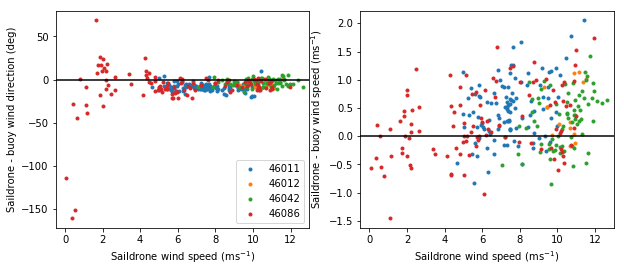

In [5]:
#make figure showing problem at low winds
sv_data=np.zeros((7,16))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
for ibuoy in range(0,6):
    if ibuoy<=6:
        xr_buoy,xr_buoy10,sbuoy_id = get_buoy_data(ibuoy) 
    else:
        xr_buoy,xr_buoy10,sbuoy_id = get_buoy_data_all()     
    btime=xr_buoy.time
    btime10=xr_buoy10.time

    #interpolate USV onto buoy 
    ilen_usv=(len(ds_usv_10min.TEMP_CTD_MEAN['time']))
    #filled=ds_usv.interpolate_na(dim='time') #fill nan by interpolating
    ds_usv10=ds_usv_10min.interp(time=btime10,method='nearest')
    ds_usvhr=ds_usv_1hr.interp(time=btime,method='nearest')
    
    dwin=.05
    dist=((ds_usvhr.lat-xr_buoy.lat)**2+(ds_usvhr.lon-xr_buoy.lon)**2)**.5
    cond,cond2 = (dist < dwin),((dist < dwin) & np.isfinite(ds_usvhr.UWND_MEAN) & np.isfinite(xr_buoy.wnd_best))
    subset_usv=ds_usvhr.where(cond,drop=True)
    subset_buoy=xr_buoy.where(cond,drop=True) #[cond]
    subset_usv_nonan=ds_usvhr.where(cond2,drop=True)
    subset_buoy_nonan=xr_buoy.where(cond2,drop=True) #[cond]
    dist=((ds_usv10.lat-xr_buoy10.lat)**2+(ds_usv10.lon-xr_buoy10.lon)**2)**.5
    cond,cond2 = (dist < dwin),((dist < dwin) & np.isfinite(ds_usv10.UWND_MEAN) & np.isfinite(xr_buoy10.wnd_best))
#    cond = (dist < dwin)
    subset_usv10=ds_usv10.where(cond,drop=True)
    subset_buoy10=xr_buoy10.where(cond,drop=True) #[cond]
    subset_usv10_nonan=ds_usv10.where(cond2,drop=True)
    subset_buoy10_nonan=xr_buoy10.where(cond2,drop=True) #[cond]

    usv_spd = np.sqrt(subset_usv10_nonan.UWND_MEAN**2+subset_usv10_nonan.VWND_MEAN**2)
    buoy_spd = np.sqrt(subset_buoy10_nonan.uwnd_best**2+subset_buoy10_nonan.vwnd_best**2)
    usv_dir = np.arctan2(subset_usv10_nonan.VWND_MEAN,subset_usv10_nonan.UWND_MEAN)*180/pi
    buoy_dir = np.arctan2(subset_buoy10_nonan.vwnd_best,subset_buoy10_nonan.uwnd_best)*180/pi
    dif_spd,dif_dir = usv_spd - buoy_spd, usv_dir - buoy_dir
    cond,cond2 = (dif_dir > 180),(dif_dir < -180)
    cond,cond2 = (dif_dir > 180),(dif_dir < -180)
    dif_dir[cond]-=360
    dif_dir[cond2]+=360
    sv_data[ibuoy,11:13]=[dif_spd.mean().data,dif_spd.std().data]
    sv_data[ibuoy,13:16]=[dif_dir.mean().data,dif_dir.std().data,dif_spd.shape[0]]
    if dif_spd.shape[0]<1:
        continue
    ax1.plot(usv_spd,dif_dir,'.')
    ax1.legend({'46011','46012','46042','46086'})
    ax1.set_xlabel('Saildrone wind speed (ms$^{-1}$)')
    ax1.set_ylabel('Saildrone - buoy wind direction (deg)')

    ax2.plot(usv_spd,dif_spd,'.')
    #ax2.legend({'46011','46012','46042','46086'})
    ax2.set_xlabel('Saildrone wind speed (ms$^{-1}$)')
    ax2.set_ylabel('Saildrone - buoy wind speed (ms$^{-1}$)')

ax1.plot([-5,15],[0,0],'k')
ax2.plot([-5,15],[0,0],'k')
ax1.set_xlim([-0.5,13])
ax2.set_xlim([-0.5,13])
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/buoy_figures/buoy_wdir_wspd_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


In [7]:
sv_data=np.zeros((7,7))
sv_data2=np.zeros((7,7))
sv_data3=np.zeros((7,7))
sv_data4=np.zeros((7,7))
sv_data5=np.zeros((7,7))
sv_data6=np.zeros((7,7))
sv_data7=np.zeros((7,7))
for ibuoy in range(0,7):

    if ibuoy<=5:
        xr_buoy,xr_buoy10,sbuoy_id = get_buoy_data(ibuoy) 
    else:
        xr_buoy,xr_buoy10,sbuoy_id = get_buoy_data_all()     
      
    #print(xr_buoy.air_pres1[0:5])
    #fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_46011_201804_D5_v00hrly_xrformat.nc'
    #xr_buoy=xr.open_dataset(fname)
    btime=xr_buoy.time
    btime10=xr_buoy10.time

    #interpolate USV onto buoy 
    ilen_usv=(len(ds_usv_10min.TEMP_CTD_MEAN['time']))
    #filled=ds_usv.interpolate_na(dim='time') #fill nan by interpolating
    ds_usv10=ds_usv_10min.interp(time=btime10,method='nearest')
    ds_usvhr=ds_usv_1hr.interp(time=btime,method='nearest')
    ds_usv10['wspd']=np.sqrt(ds_usv10.UWND_MEAN**2+ds_usv10.VWND_MEAN**2)
    ds_usvhr['wspd']=np.sqrt(ds_usvhr.UWND_MEAN**2+ds_usvhr.VWND_MEAN**2)
    
    dwin=.05
    bair=xr_buoy.air1
    dist=((ds_usvhr.lat-xr_buoy.lat)**2+(ds_usvhr.lon-xr_buoy.lon)**2)**.5
    cond,cond2 = (dist < dwin),((dist < dwin) & np.isfinite(ds_usvhr.UWND_MEAN) & np.isfinite(xr_buoy.wnd_best))
    cond3 = ((dist < dwin) & np.isfinite(ds_usvhr.UWND_MEAN) & np.isfinite(xr_buoy.wnd_best) & (ds_usvhr.wspd>3.5))
    subset_usv=ds_usvhr.where(cond,drop=True)
    subset_buoy=xr_buoy.where(cond,drop=True) #[cond]
    subset_usv_nonan=ds_usvhr.where(cond2,drop=True)
    subset_buoy_nonan=xr_buoy.where(cond2,drop=True) #[cond]
    subset_usv_nonan_nolow=ds_usvhr.where(cond3,drop=True)
    subset_buoy_nonan_nolow=xr_buoy.where(cond3,drop=True) #[cond]

    dist=((ds_usv10.lat-xr_buoy10.lat)**2+(ds_usv10.lon-xr_buoy10.lon)**2)**.5
    cond,cond2 = (dist < dwin),((dist < dwin) & np.isfinite(ds_usv10.UWND_MEAN) & np.isfinite(xr_buoy10.wnd_best))
    cond3 = ((dist < dwin) & np.isfinite(ds_usv10.UWND_MEAN) & np.isfinite(xr_buoy10.wnd_best) & (ds_usv10.wspd>3.5))
    subset_usv10=ds_usv10.where(cond,drop=True)
    subset_buoy10=xr_buoy10.where(cond,drop=True) #[cond]
    subset_usv10_nonan=ds_usv10.where(cond2,drop=True)
    subset_buoy10_nonan=xr_buoy10.where(cond2,drop=True) #[cond]
    subset_usv10_nonan_nolow=ds_usv10.where(cond3,drop=True)
    subset_buoy10_nonan_nolow=xr_buoy10.where(cond3,drop=True) #[cond]

    print(sbuoy_id) #,subset_usv.shape)
    sdif = (subset_usv.TEMP_CTD_MEAN-subset_buoy.sst_best+273.15).dropna('time')
    sdifcor = np.corrcoef(subset_usv.TEMP_CTD_MEAN,subset_buoy.sst_best-273.15)[0,1]
    std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
    ilen = sdif.shape[0]
    sv_data[ibuoy,0:7]=[sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                        np.abs(sdif).mean().data,sdif.shape[0]]

    sdif = (subset_usv.TEMP_AIR_MEAN-subset_buoy.air_best+273.15).dropna('time')
    sdifcor = np.corrcoef(subset_usv.TEMP_AIR_MEAN,subset_buoy.air_best-273.15)[0,1]
    std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
    print('air:') #,(sdif).mean().data,(sdif).std().data,sdif.shape[0])
    sv_data2[ibuoy,0:7]=[sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                        np.abs(sdif).mean().data,sdif.shape[0]]

    sdif = (subset_usv.BARO_PRES_MEAN-subset_buoy.air_pres_best).dropna('time')
    sdifcor = np.corrcoef(subset_usv.BARO_PRES_MEAN,subset_buoy.air_pres_best)[0,1]
    std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
    sv_data3[ibuoy,0:7]=[sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                        np.abs(sdif).mean().data,sdif.shape[0]]
   
    usv_spd = np.sqrt(subset_usv_nonan.UWND_MEAN**2+subset_usv_nonan.VWND_MEAN**2)
    buoy_spd = np.sqrt(subset_buoy_nonan.uwnd_best**2+subset_buoy_nonan.vwnd_best**2)
    usv_dir = np.arctan2(subset_usv_nonan_nolow.VWND_MEAN,subset_usv_nonan_nolow.UWND_MEAN)*180/pi
    buoy_dir = np.arctan2(subset_buoy_nonan_nolow.vwnd_best,subset_buoy_nonan_nolow.uwnd_best)*180/pi
    dif_spd,dif_dir = usv_spd - buoy_spd, usv_dir - buoy_dir
    cond,cond2 = (dif_dir > 180),(dif_dir < -180)
    dif_dir[cond]-=360
    dif_dir[cond2]+=360
    print('wnd_spd:',dif_spd.mean().data,dif_spd.std().data)
    print('wnd_dir:',dif_dir.mean().data,dif_dir.std().data)
    sdifcor = np.corrcoef(usv_spd,buoy_spd)[0,1]
    std_robust = np.nanmedian(np.abs(dif_spd - np.nanmedian(dif_spd))) * 1.482602218505602
    sdif = dif_spd
    sv_data4[ibuoy,0:7]=[sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                        np.abs(sdif).mean().data,sdif.shape[0]]   
    sdifcor = np.corrcoef(usv_dir,buoy_dir)[0,1]
    std_robust = np.nanmedian(np.abs(dif_dir - np.nanmedian(dif_dir))) * 1.482602218505602   
    sdif = dif_dir
    sv_data5[ibuoy,0:7]=[sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                        np.abs(sdif).mean().data,sdif.shape[0]]

    usv_spd = np.sqrt(subset_usv10_nonan.UWND_MEAN**2+subset_usv10_nonan.VWND_MEAN**2)
    buoy_spd = np.sqrt(subset_buoy10_nonan.uwnd_best**2+subset_buoy10_nonan.vwnd_best**2)
    usv_dir = np.arctan2(subset_usv10_nonan_nolow.VWND_MEAN,subset_usv10_nonan_nolow.UWND_MEAN)*180/pi
    buoy_dir = np.arctan2(subset_buoy10_nonan_nolow.vwnd_best,subset_buoy10_nonan_nolow.uwnd_best)*180/pi
    dif_spd,dif_dir = usv_spd - buoy_spd, usv_dir - buoy_dir
    cond,cond2 = (dif_dir > 180),(dif_dir < -180)
    dif_dir[cond]-=360
    dif_dir[cond2]+=360
    print('wnd_spd:',dif_spd.mean().data,dif_spd.std().data,dif_spd.shape[0])
    print('wnd_dir:',dif_dir.mean().data,dif_dir.std().data,dif_dir.shape[0])
    sdifcor = np.corrcoef(usv_spd,buoy_spd)[0,1]
    std_robust = np.nanmedian(np.abs(dif_spd - np.nanmedian(dif_spd))) * 1.482602218505602
    sdif = dif_spd
    sv_data6[ibuoy,0:7]=[sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                        np.abs(sdif).mean().data,sdif.shape[0]]   
    sdifcor = np.corrcoef(usv_dir,buoy_dir)[0,1]
    std_robust = np.nanmedian(np.abs(dif_dir - np.nanmedian(dif_dir))) * 1.482602218505602   
    sdif = dif_dir
    sv_data7[ibuoy,0:7]=[sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                        np.abs(sdif).mean().data,sdif.shape[0]]   

    


46011
air:
wnd_spd: 0.6168111360932461 0.5860456292985011
wnd_dir: -8.455760052008019 6.054220769073243
wnd_spd: 0.4660817854186119 0.5197594865825381 112
wnd_dir: -8.387298194743568 4.510242168075965 112
46012
air:
wnd_spd: 0.28481975818287264 0.5109829778620609
wnd_dir: -4.114764400354977 5.79316910510895
wnd_spd: 0.46024251583249015 0.47472206553727947 13
wnd_dir: -4.574648083654851 3.048717205163894 13
46042
air:
wnd_spd: 0.00809500396562779 0.6459652202565059
wnd_dir: -4.099836363937346 5.454487861924321
wnd_spd: 0.2972729778764195 0.48095391985186886 74
wnd_dir: -3.203778881477334 4.0020687316935355 74
46086
air:
wnd_spd: 0.5466600154417284 0.7076986931345871
wnd_dir: -7.407391328765909 8.676409886635781
wnd_spd: 0.23664226146617318 0.6005980229281548 108
wnd_dir: -6.364182285244724 7.445585995074709 80
46028
air:
wnd_spd: nan nan
wnd_dir: nan nan
wnd_spd: nan nan 0
wnd_dir: nan nan 0


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encounter

46047
air:
wnd_spd: nan nan
wnd_dir: nan nan
wnd_spd: nan nan 0
wnd_dir: nan nan 0


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encounter

460114601246042460864602846047
air:
wnd_spd: 0.4275801236854172 0.6899175900320444
wnd_dir: -6.776232548808608 6.987847918821713
wnd_spd: 0.34442956766745486 0.5489482246182074 307
wnd_dir: -6.254702662894958 5.759566814873214 279


In [ ]:
sdif = (subset_usv.BARO_PRES_MEAN-subset_buoy.air_pres_best).dropna('time')
sdifcor = np.corrcoef(subset_usv.BARO_PRES_MEAN,subset_buoy.air_pres_best)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])


In [ ]:
plt.plot(np.abs(sdif - np.nanmedian(sdif)))
print(np.nanmedian(np.abs(sdif - np.nanmedian(sdif))))
print(sdif.std().data)
#this is explaining why the STD is larger than the robust STD 
#robust STD uses median which removes the spikes since there aren't many of them


In [ ]:
#this shows that the pressure sensor sometimes goes back to the right observation!  odd.
plt.plot(subset_usv.BARO_PRES_MEAN,'.')
plt.plot(subset_buoy.air_pres_best,'.')

In [ ]:
plt.plot(ds_usv_10min.BARO_PRES_MEAN[1000:2000])

In [ ]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
for i in range(7):
    print(sv_data[i,:])
for i in range(0,7):
    print(sv_data2[i,:])
for i in range(0,7):
    print(sv_data3[i,:])
for i in range(0,7):
    print(sv_data4[i,:])
for i in range(0,7):
    print(sv_data5[i,:])
for i in range(0,7):
    print(sv_data6[i,:])
for i in range(0,7):
    print(sv_data7[i,:])
    

In [ ]:
#plot buoy and saildrone data

fig, (ax1, ax2) = plt.subplots(1,2)

for ibuoy in range(0,6):

    xr_buoy,xr_buoy10,sbuoy_id = get_buoy_data(ibuoy)
      
    btime=xr_buoy.time
    btime10=xr_buoy10.time
    #interpolate USV onto buoy 
    ilen_usv=(len(ds_usv_10min.TEMP_CTD_MEAN['time']))
    #filled=ds_usv.interpolate_na(dim='time') #fill nan by interpolating
    ds_usv10=ds_usv_10min.interp(time=btime10,method='nearest')
    ds_usvhr=ds_usv_1hr.interp(time=btime,method='nearest')
    ds_usv10['wspd']=np.sqrt(ds_usv10.UWND_MEAN**2+ds_usv10.VWND_MEAN**2)
    ds_usvhr['wspd']=np.sqrt(ds_usvhr.UWND_MEAN**2+ds_usvhr.VWND_MEAN**2)

        
        #print(xr_buoy.air_pres1[0:5])
    #fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_46011_201804_D5_v00hrly_xrformat.nc'
    #xr_buoy=xr.open_dataset(fname)
#    cond = xr_buoy.lat > 90
#    xr_buoy.lat[cond]=np.nan
##    cond = xr_buoy.lon > 90
##    xr_buoy.lon[cond]=np.nan
 #   blat=xr_buoy.lat.mean()
 #   blon=xr_buoy.lon.mean()
 #   btime=xr_buoy.time

    #interpolate USV onto buoy 
  #  ilen_usv=(len(ds_usv_1hr.TEMP_CTD_MEAN['time']))
    #filled=ds_usv.interpolate_na(dim='time') #fill nan by interpolating
  #  ds_usv10=ds_usv_10min.interp(time=btime10,method='nearest')
  #  ds_usvhr=ds_usv_1hr.interp(time=btime,method='nearest')
    
    fig, (ax1, ax2) = plt.subplots(1,2)


    dwin=.05
    dist=((ds_usvhr.lat-xr_buoy.lat)**2+(ds_usvhr.lon-xr_buoy.lon)**2)**.5
    cond = (dist < dwin)
    subset_usv=ds_usvhr.where(cond,drop=True)
    subset_buoy=xr_buoy.where(cond,drop=True) #[cond]
    dist=((ds_usv10.lat-xr_buoy10.lat)**2+(ds_usv10.lon-xr_buoy10.lon)**2)**.5
    cond = (dist < dwin)
    subset_usv10=ds_usv10.where(cond,drop=True)
    subset_buoy10=xr_buoy10.where(cond,drop=True) #[cond]

    ax1.scatter(subset_usv10.lon,subset_usv10.lat, c=subset_usv10.TEMP_CTD_MEAN,s=5,marker = "o")
    ax1.scatter(subset_buoy.lon,subset_buoy.lat, c=subset_buoy.sst_best,s=5,marker="D")
    ax1.quiver(subset_usv10.lon,subset_usv10.lat,subset_usv10.UWND_MEAN,subset_usv10.VWND_MEAN,color='k')
    ax1.quiver(subset_buoy10.lon,subset_buoy10.lat,subset_buoy10.uwnd_best,subset_buoy10.vwnd_best,color='r')
    ax1.legend(['USV','buoy'])
    ymin, ymax = ax1.get_ylim()
    xmin, xmax = ax1.get_xlim()
#    print(xmin,xmax,ymin,ymax)
    ax2.scatter(ds_usv.lon[0::60],ds_usv.lat[0::60], c=ds_usv.TEMP_CTD_MEAN[0::60],s=5,marker = "o")
    ax2.scatter(xr_buoy.lon[0::60],xr_buoy.lat[0::60], c=xr_buoy.sst_best[0::60],s=5,marker="D")
    ax2.quiver(ds_usv.lon[0::60],ds_usv.lat[0::60],ds_usv.UWND_MEAN[0::60],ds_usv.VWND_MEAN[0::60],color='k')
    ax2.quiver(xr_buoy.lon[0::60],xr_buoy.lat[0::60],xr_buoy.uwnd_best[0::60],xr_buoy.vwnd_best[0::60],color='r')
    ax2.legend(['USV','buoy'])
    ax2.set_ylim(ymin,ymax)
    ax2.set_xlim(xmin,xmax)
    
    #ax2.plot(subset_usv10.time,subset_usv10.TEMP_CTD_MEAN-273.15,'.')
    #ax2.plot(subset_buoy.time,subset_buoy.best_sst)
 #   ax2.set_xlim(tstart_buffer,tend_buffer)
 #   ax2.set_ylim(11,14.5)
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/buoy_figures/buoy_loc_image'+sbuoy_id+'_test.png'
    fig.savefig(fig_fname, transparent=False, format='png')
    plt.clf()



In [ ]:
#plot buoy and saildrone data all on one figure

fig, ax0 = plt.subplots(1,6)

for ibuoy in range(0,6):

    xr_buoy,xr_buoy10,sbuoy_id = get_buoy_data(ibuoy)
      
    #print(xr_buoy.air_pres1[0:5])
    #fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_46011_201804_D5_v00hrly_xrformat.nc'
    #xr_buoy=xr.open_dataset(fname)
    cond = xr_buoy.lat > 90
    xr_buoy.lat[cond]=np.nan
    cond = xr_buoy.lon > 90
    xr_buoy.lon[cond]=np.nan
    blat=xr_buoy.lat.mean()
    blon=xr_buoy.lon.mean()
    btime=xr_buoy.time
      
    dwin=.05
    subset=ds_usv.copy(deep=True) #sel(time=slice(time_start1,time_end1))
    lat_usv=subset.lat
    lon_usv=subset.lon
    time_usv=subset.time
    sst_usv=subset.TEMP_CTD_MEAN

    meets_condition = (lat_usv>blat-dwin) & (lat_usv<blat+dwin) & (lon_usv>blon-dwin) & (lon_usv<blon+dwin) #& time_usv<dt.datetime('2018-04-20')
    if (lon_usv[meets_condition].shape[0]==0):
        continue
    ax1.scatter(lon_usv[meets_condition],lat_usv[meets_condition], c=sst_usv[meets_condition], s=5)
    ax1.plot(xr_buoy.lon.sel(time=slice(tstart_buffer,tend_buffer)),xr_buoy.lat.sel(time=slice(tstart_buffer,tend_buffer)),'r.')
    ax1.legend(['Buoy','USV'])
    ax2.plot(subset.time[meets_condition],subset.TEMP_CTD_MEAN[meets_condition]-273.15,'.')
    ax2.plot(xr_buoy.time,xr_buoy.sst1-273.15)
    ax2.set_xlim(tstart_buffer,tend_buffer)
    ax2.set_ylim(11,14.5)
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/buoy_figures/buoy_loc_image'+sbuoy_id+'_.png'
    fig.savefig(fig_fname, transparent=False, format='png')
    plt.clf()

    dwin=.02
    meets_condition = (lat_usv>blat-dwin) & (lat_usv<blat+dwin) & (lon_usv>blon-dwin) & (lon_usv<blon+dwin) #& time_usv<dt.datetime('2018-04-20')
    fig, (ax1, ax2) = plt.subplots(1,2)
    if (lon_usv[meets_condition].shape[0]==0):
        continue
    ax1.scatter(lon_usv[meets_condition],lat_usv[meets_condition], c=sst_usv[meets_condition], s=5)
    ax1.plot(xr_buoy.lon.sel(time=slice(tstart_buffer,tend_buffer)),xr_buoy.lat.sel(time=slice(tstart_buffer,tend_buffer)),'r.')
    ax1.legend(['Buoy','USV'])
    ax2.plot(subset.time[meets_condition],subset.TEMP_CTD_MEAN[meets_condition]-273.15,'.')
    ax2.plot(xr_buoy.time,xr_buoy.sst1-273.15)
    ax2.set_xlim(tstart_buffer,tend_buffer)
    ax2.set_ylim(11,14.5)
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/buoy_figures/buoy_loc_image'+sbuoy_id+'_02km.png'
    fig.savefig(fig_fname, transparent=False, format='png')
    plt.clf()

    #now i only use part of buoy location that is for this time
    dwin=.01
#        blon_subset=xr_buoy.lon.sel(time=slice(time_start1,time_end1)).mean()
#        blat_subset=xr_buoy.lat.sel(time=slice(time_start1,time_end1)).mean()
    meets_condition = (lat_usv>blat-dwin) & (lat_usv<blat+dwin) & (lon_usv>blon-dwin) & (lon_usv<blon+dwin) #& time_usv<dt.datetime('2018-04-20')
#        meets_condition = (lat_usv>blat_subset-dwin) & (lat_usv<blat_subset+dwin) & (lon_usv>blon_subset-dwin) & (lon_usv<blon_subset+dwin) #& time_usv<dt.datetime('2018-04-20')
    fig, (ax1, ax2) = plt.subplots(1,2)
    if (lon_usv[meets_condition].shape[0]==0):
        continue
    ax1.scatter(lon_usv[meets_condition],lat_usv[meets_condition], c=sst_usv[meets_condition], s=5)
    ax1.plot(xr_buoy.lon.sel(time=slice(time_start1,time_end1)),xr_buoy.lat.sel(time=slice(time_start1,time_end1)),'r.')
    ax1.legend(['Buoy','USV'])
    ax2.plot(subset.time[meets_condition],subset.TEMP_CTD_MEAN[meets_condition]-273.15,'.')
    ax2.plot(xr_buoy.time,xr_buoy.sst1-273.15)
    ax2.set_xlim(time_start1,time_end1)
    ax2.set_ylim(11,14.5)
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/buoy_figures/buoy_loc_image'+sbuoy_id+'_01km.png'
    fig.savefig(fig_fname, transparent=False, format='png')
    plt.clf()


In [ ]:
#####old
filename_usv='F:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
#ds_usv_tem=xr.open_dataset(filename_usv)
ds_usv = read_saildrone(filename_usv)
ilen_usv=(len(ds_usv.TEMP_CTD_MEAN['time']))
filled=ds_usv.interpolate_na(dim='time') #fill nan by interpolating
#move lat and lon into variables so that they don't disappear when interpolating
lon = ds_usv.lon
lat = ds_usv.lat
del ds_usv['lon']
del ds_usv['lat']
ds_usv['lon'] = ('time', lon)
ds_usv['lat'] = ('time', lat)
ds_usv10=filled.interp(time=btime10)
ds_usvhr=filled.interp(time=btime)

#this take the average from min: 01 to :10 and assigns it :10
#use this for the wind comparisons since they are 10 min ave
subset = ds_usv.sel(time=slice('2018-04-10','2018-04-13'))
ds_usv_10min = ds_usv.resample(time='10min', skipna=True, closed='right', label='right').mean('time') 

#this calculates hourly data that only uses the last 8 minutes of each hour for the average
#use this for the hourly data comparisons
sub = ds_usv.copy(deep=True)
pt = pd.to_datetime(sub.time.data)
pmin=pt.minute
tem=sub.where(pmin>=52)  #data average should be only use min 52  to :60 
ds_usv_1hr = tem.resample(time='1h', skipna=True, label='right').mean()


In [ ]:
filename_usv='F:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = read_saildrone(filename_usv)
#ds_usv.close()
ilen_usv=(len(ds_usv.TEMP_CTD_MEAN['time']))
filled=ds_usv.interpolate_na(dim='time') #fill nan by interpolating
#ds_usv10=filled.interp(time=btime10)
#ds_usvhr=filled.interp(time=btime)
#ds_usv10=filled.resample(time='10Min').mean()  #this code creates 10 averages
#ds_usvhr=filled.resample(time='1H').mean()   #this code creates hourly averages
#this take the average from min: 01 to :10 and assigns it :10
ds_usv_10min = ds_usv.resample(time='10min', skipna=True, closed='right', label='right').mean('time') 

#this calculates hourly data that only uses the last 8 minutes of each hour for the average
sub = ds_usv.copy(deep=True)
pt = pd.to_datetime(sub.time.data)
pmin=pt.minute
tem=sub.where(pmin>=52)  #data average should be only use min 52  to :60 
ds_usv_1hr = tem.resample(time='1h', skipna=True, label='right').mean()

#dates_usv64=ds_usv.time[0,:].values
#dates_usv=pd.to_datetime(dates_usv64, unit='ns')  #new way to caluclate the time array

In [ ]:
#ds=xr.open_dataset(filename_usv)
#ds = ds.sel(trajectory=1002)
#ds=ds.rename({'latitude':'lat','longitude':'lon'})
#ds=ds.swap_dims({'obs':'time'})
#print(ds)
#print(ds.time[0:10])
#print(xr_buoy.wnd_best[0:2])
for i in range(1,2):
    print(i,xr_buoy.time[i].data,xr_buoy.wnd_best[i].data)
print('10min')
for i in range(0,15):
    print(i,xr_buoy10.time[i].data,xr_buoy10.wnd_best[i].data)
print(xr_buoy10.wnd_best[6:12].mean().data)

subset = ds_usv.sel(time=slice('2018-04-10','2018-04-13'))

xftem=subset.UWND_MEAN
pt = pd.to_datetime(xftem.time.data)
pmin=pt.minute
tem=xftem[(pmin >=52)]  #data average should be only use min 52  to :60 
new_hr = tem.resample(time='1h').mean()
for i in range(0,1):
    print(new_hr.time[i].data,new_hr[i].data)
print(xftem[52:60].mean().data)    

#xftem=subset.UWND_MEAN
sub = subset.copy(deep=True)
pt = pd.to_datetime(sub.time.data)
pmin=pt.minute
#sub['mask']=pmin
tem=sub.where(pmin>=52)  #data average should be only use min 52  to :60 
new_hr = tem.resample(time='1h', label='right').mean()

#print(new_hr)
for i in range(0,1):
    print(new_hr.time[i].data,new_hr.UWND_MEAN[i].data)
#print('min')
#for i in range(0,60):
#    print(i,xftem.time[i].data,xftem[i].data)
print(subset.UWND_MEAN[52:60].mean().data)    

In [ ]:
#read in high resolution wind buoy data (10 minute)
sbuoy_id='46011'
sdep='D5'
fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201804_'+sdep+'_v0010min_xrformat.nc'
xr_buoy10=xr.open_dataset(fname)
fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201805_'+sdep+'_v0010min_xrformat.nc'
tem=xr.open_dataset(fname)
xr_buoy10 = xr.concat([xr_buoy10, tem],'time')
fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201806_'+sdep+'_v0010min_xrformat.nc'
tem=xr.open_dataset(fname)
xr_buoy10 = xr.concat([xr_buoy10, tem],'time')
btime10=xr_buoy10.time#read in hourly buoy data
fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201804_'+sdep+'_v00hrly_xrformat.nc'
xr_buoy=xr.open_dataset(fname)
fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201805_'+sdep+'_v00hrly_xrformat.nc'
tem=xr.open_dataset(fname)
xr_buoy = xr.concat([xr_buoy, tem],'time')
fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_'+sbuoy_id+'_201806_'+sdep+'_v00hrly_xrformat.nc'
tem=xr.open_dataset(fname)
xr_buoy = xr.concat([xr_buoy, tem],'time')
time=xr_buoy.time
#fname='F:/data/cruise_data/saildrone/baja-2018/buoy_data/NDBC_46011_201804_D5_v00hrly_xrformat.nc'
#xr_buoy=xr.open_dataset(fname)
cond = xr_buoy.lat > 90
xr_buoy.lat[cond]=np.nan
cond = xr_buoy.lon > 90
xr_buoy.lon[cond]=np.nan
blat=xr_buoy.lat.mean()
blon=xr_buoy.lon.mean()
btime=xr_buoy.time


In [ ]:
    dwin=.02
    meets_condition = (lat_usv>blat-dwin) & (lat_usv<blat+dwin) & (lon_usv>blon-dwin) & (lon_usv<blon+dwin) #& time_usv<dt.datetime('2018-04-20')
    fig, (ax1, ax2) = plt.subplots(1,2)
    if (lon_usv[meets_condition].shape[0]==0):
        continue
    ax1.scatter(lon_usv[meets_condition],lat_usv[meets_condition], c=sst_usv[meets_condition], s=5)
    ax1.plot(xr_buoy.lon.sel(time=slice(tstart_buffer,tend_buffer)),xr_buoy.lat.sel(time=slice(tstart_buffer,tend_buffer)),'r.')
    ax1.legend(['Buoy','USV'])
    ax2.plot(subset.time[meets_condition],subset.TEMP_CTD_MEAN[meets_condition]-273.15,'.')
    ax2.plot(xr_buoy.time,xr_buoy.sst1-273.15)
    ax2.set_xlim(tstart_buffer,tend_buffer)
    ax2.set_ylim(11,14.5)
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/buoy_figures/buoy_loc_image'+sbuoy_id+'_02km.png'
    fig.savefig(fig_fname, transparent=False, format='png')
    plt.clf()

    #now i only use part of buoy location that is for this time
    dwin=.01
#        blon_subset=xr_buoy.lon.sel(time=slice(time_start1,time_end1)).mean()
#        blat_subset=xr_buoy.lat.sel(time=slice(time_start1,time_end1)).mean()
    meets_condition = (lat_usv>blat-dwin) & (lat_usv<blat+dwin) & (lon_usv>blon-dwin) & (lon_usv<blon+dwin) #& time_usv<dt.datetime('2018-04-20')
#        meets_condition = (lat_usv>blat_subset-dwin) & (lat_usv<blat_subset+dwin) & (lon_usv>blon_subset-dwin) & (lon_usv<blon_subset+dwin) #& time_usv<dt.datetime('2018-04-20')
    fig, (ax1, ax2) = plt.subplots(1,2)
    if (lon_usv[meets_condition].shape[0]==0):
        continue
    ax1.scatter(lon_usv[meets_condition],lat_usv[meets_condition], c=sst_usv[meets_condition], s=5)
    ax1.plot(xr_buoy.lon.sel(time=slice(time_start1,time_end1)),xr_buoy.lat.sel(time=slice(time_start1,time_end1)),'r.')
    ax1.legend(['Buoy','USV'])
    ax2.plot(subset.time[meets_condition],subset.TEMP_CTD_MEAN[meets_condition]-273.15,'.')
    ax2.plot(xr_buoy.time,xr_buoy.sst1-273.15)
    ax2.set_xlim(time_start1,time_end1)
    ax2.set_ylim(11,14.5)
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/buoy_figures/buoy_loc_image'+sbuoy_id+'_01km.png'
    fig.savefig(fig_fname, transparent=False, format='png')
    plt.clf()
